# Preliminary Results


In [1]:
# Load the necessary packages.
library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
v purrr   0.3.5      
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


## Importing Data

### Table 1: Top 6 Rows of Forest Fires Data

In [2]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
download.file (url,"../data/forestfires.csv" )

forest_fires_data <-read_delim("../data/forestfires.csv", skip=0, delim=",") %>%
    select(wind, area) %>%
    mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(wind) | !is.na(area))
    
head(forest_fires_data)

Rows: 517 Columns: 13
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area
<dbl>,<dbl>
6.7,0
0.9,0
1.3,0
4.0,0
1.8,0
5.4,0


## Wind Speed Distributions

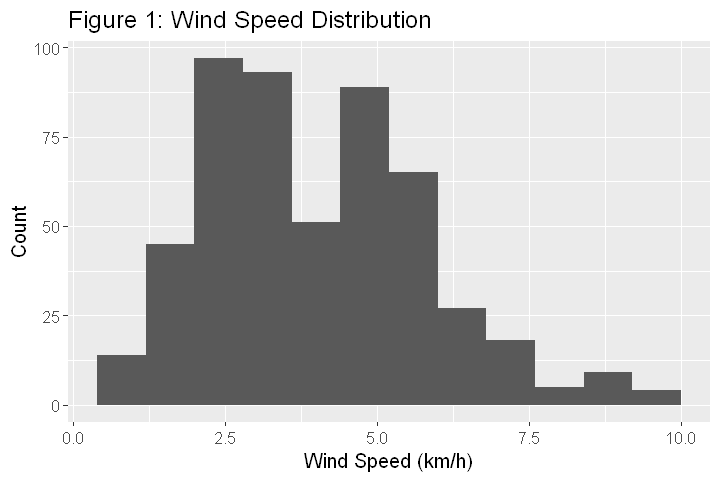

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)
wind_speed_plot <- forest_fires_data %>%
    ggplot(aes(x = wind))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 1: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12)) 
wind_speed_plot

Based on figure 1, wind speed is almost a bimodal distribution (without much modification), we can safely assume that we can categorize wind speed into "high" and "low".

wind,area,category
<dbl>,<dbl>,<fct>
6.7,0,high
0.9,0,low
1.3,0,low
4.0,0,low
1.8,0,low
5.4,0,high


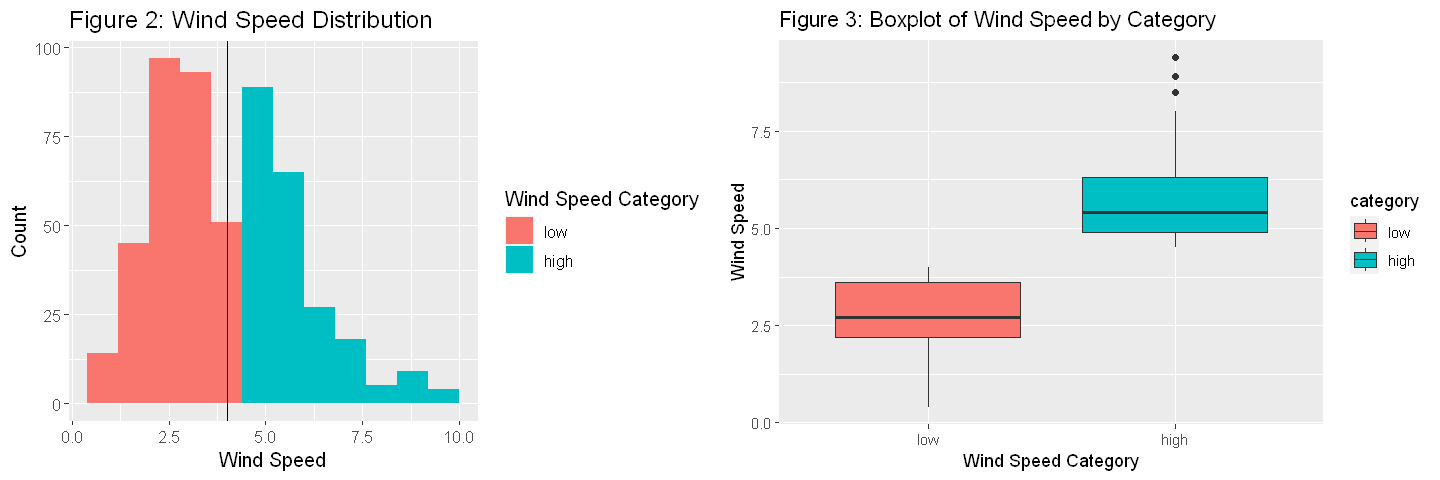

In [4]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

# add category column
forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))
head(forest_fires_data)

wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x =wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed", y="Count")+
    ggtitle("Figure 2: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))

box_plot <- forest_fires_data %>%
  ggplot(aes(x = category, y = wind, fill = category)) +
  geom_boxplot() +
  labs(x="Wind Speed Category", y="Wind Speed") +
  ggtitle("Figure 3: Boxplot of Wind Speed by Category") 

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(wind_plot_categorized, box_plot)

Based on Figure 3, there is a considerable difference in wind speed. A confidence interval would be useful to see if their ranges overlap in a interesting manner. We could also have a confidence interval around the difference of the mean.

## Area Burned Distributions

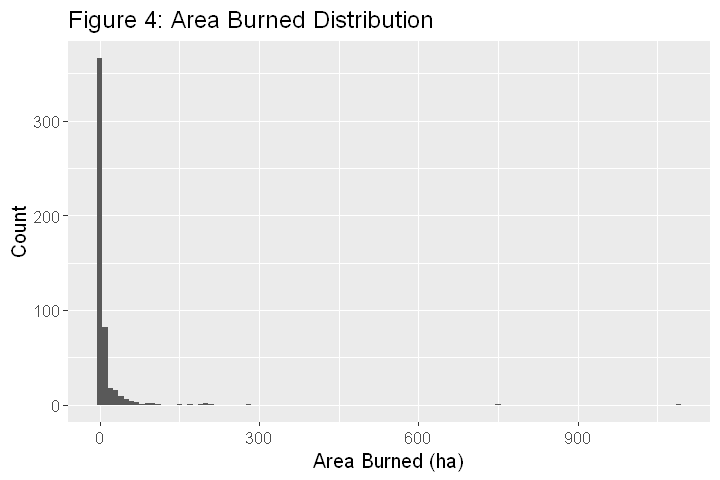

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4)

#Visualizing the distribution of each variable
area_burned_plot <- forest_fires_data %>%
    ggplot(aes(x =area))+
    geom_histogram(binwidth = 10) + 
    labs(x="Area Burned (ha)", y="Count")+
    ggtitle("Figure 4: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12))
area_burned_plot   

Figure 4 shows that it make sense to scale the data in a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [6]:
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(1+ area))

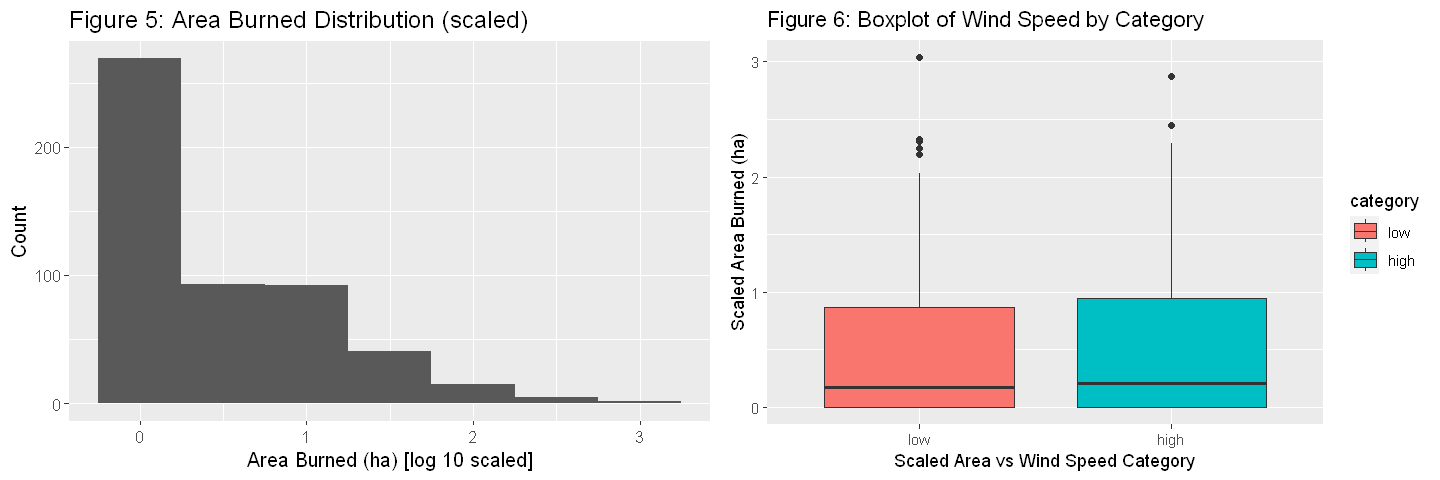

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4)

area_burned_scaled_plot <- forest_fires_data %>%
    ggplot(aes(x =area_log10))+
    geom_histogram(binwidth = 0.5) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 5: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12))

box_plot_burned <- forest_fires_data %>%
  ggplot(aes(x = category, y = area_log10, fill = category)) +
  geom_boxplot() +
  labs(x="Scaled Area vs Wind Speed Category", y="Scaled Area Burned (ha)")+
  ggtitle("Figure 6: Boxplot of Wind Speed by Category")

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(area_burned_scaled_plot, box_plot_burned)

##### Table 2: Summary Statistics of Forest Fires Data

In [8]:
forest_fires_data %>%
group_by(category) %>%
filter(category == "low") %>%
summary()

forest_fires_data %>%
group_by(category) %>%
filter(category == "high") %>%
summary()

      wind            area          category     area_log10    
 Min.   :0.400   Min.   :   0.000   low :300   Min.   :0.0000  
 1st Qu.:2.200   1st Qu.:   0.000   high:  0   1st Qu.:0.0000  
 Median :2.700   Median :   0.495              Median :0.1746  
 Mean   :2.779   Mean   :  12.615              Mean   :0.4699  
 3rd Qu.:3.600   3rd Qu.:   6.365              3rd Qu.:0.8672  
 Max.   :4.000   Max.   :1090.840              Max.   :3.0382  

      wind            area        category     area_log10    
 Min.   :4.500   Min.   :  0.00   low :  0   Min.   :0.0000  
 1st Qu.:4.900   1st Qu.:  0.00   high:217   1st Qu.:0.0000  
 Median :5.400   Median :  0.61              Median :0.2068  
 Mean   :5.729   Mean   : 13.17              Mean   :0.5000  
 3rd Qu.:6.300   3rd Qu.:  7.73              3rd Qu.:0.9410  
 Max.   :9.400   Max.   :746.28              Max.   :2.8735  